In [211]:
%load_ext autoreload
%autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [268]:
import sys
sys.path.insert(1, '/home/gusinskaia/scintools/scintools')
import ththmod as THTH

In [269]:
import baseband
from baseband import guppi
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pulsarbat as pb
from glob import glob
import os, sys, math, time

from astropy.time import Time
from astropy import units as u
from astropy.visualization import quantity_support

from astropy import constants as const

import numpy as np
import astropy
from matplotlib.colors import LogNorm

import matplotlib as mpl
from scipy.sparse.linalg import eigsh
from scipy.optimize import curve_fit
import scipy.linalg

import load_data as ld
import ds_psr as dsa
import fit_thth as fth
import models_thth as mth


plt.rcParams['figure.dpi'] = 50
print (baseband.__version__)
print (pb.__version__)
print (astropy.__version__)


import concurrent.futures
import datetime


4.0.1
0.0.3
3.0


In [205]:
trdir='/mnt/scratch-lustre/gusinskaia/triple_system/'
odir=trdir+'dss_mean/'
fitdir=trdir+'for_fit/'
npydir=trdir+'npys_vels/'
imdir=trdir+'fitted_figures/'
vlbidir=trdir+'dss_realvlba/'
longdir=trdir+'dss_long/'
onetotwo_dir=trdir+'dss_1to2/'
twotofour_dir=trdir+'dss_2to4/'
armdir=trdir+'one_armed_arc/'
nsdir=trdir+'dss_wsrt_wnoise/'

spec_pieces=np.array([[1301,1317],[1321,1337],[1341,1357],[1361,1377],[1381,1397],
                      [1401,1417],[1421,1437],[1441,1457]])

In [141]:
ao_data=dsa.load_triple_spectrum('/mnt/scratch-lustre/gusinskaia/triple_system/dss_realvlba/5602579_AO_1400real_vlbi_ds.npz',
                      wnoise=False)

(867, 512)


In [306]:
list_2to4=sorted(glob(nsdir+'*.npz'))
#list_2to4

(1799, 512)
(112, 512)
(112, 512)
(112, 512) (112, 512)


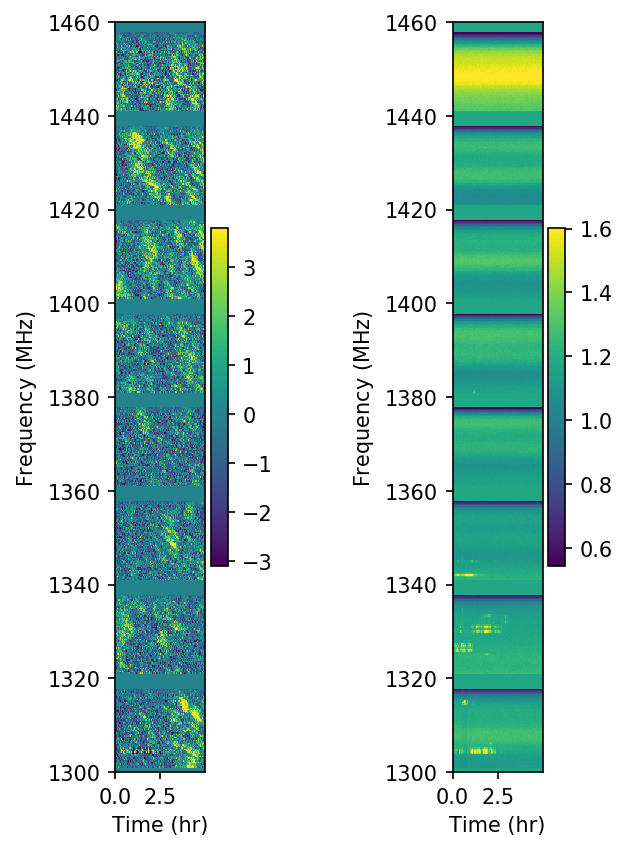

In [317]:
sp=dsa.load_triple_spectrum(list_2to4[4], factor=[16,1], wnoise=True, mean0=True)
print (np.shape(sp.I), np.shape(sp.nI))

i=6
spec_sel2=sp.select(time_sel=[sp.stend[0]*u.d,sp.stend[1]*u.d],
                                            freq_sel=[spec_pieces[i,0]*u.MHz,spec_pieces[i,1]*u.MHz])

spec_sel2.ss=spec_sel2.make_ss(pad_it=True, npad=3)


fig=plt.figure(figsize=(3,5), dpi=150)
fig.add_axes([0.0,0.0,0.25,1])
plt.gca()
sp.plot_ds(new_fig=False)
plt.colorbar()
fig.add_axes([0.75,0.0,0.25,1])
plt.gca()
sp.plot_nds(new_fig=False)
plt.colorbar()

In [275]:
this_spec=dsa.load_triple_spectrum(list_2to4[4], factor=[1,1], wnoise=True)
i=6
spec_sel=this_spec.select(time_sel=[this_spec.stend[0]*u.d,this_spec.stend[1]*u.d],
                                            freq_sel=[spec_pieces[i,0]*u.MHz,spec_pieces[i,1]*u.MHz])

spec_sel.ss=spec_sel.make_ss(pad_it=True, npad=3)

(1799, 512)
(1799, 512)
(1799, 512)


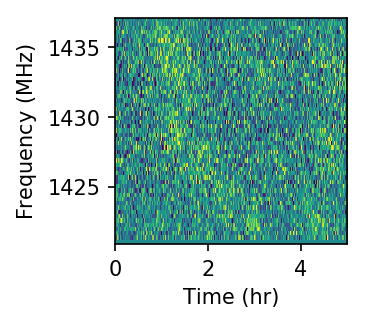

In [300]:
spec_sel.plot_ds(figsize=(2,2))

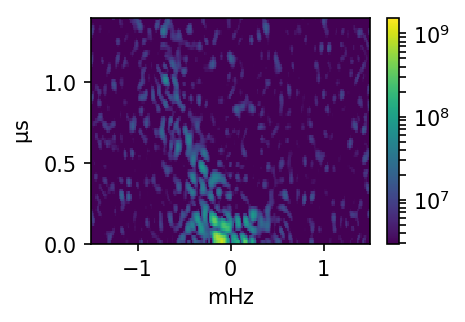

In [284]:
spec_sel.plot_ss()

In [324]:
#try thth_redplot
fitdic, fit_freq, fit_time, res_dic=fth.daniel_pars_fit(spec_sel, curv_par='dveff', etas_pars=[0.5,11.5,0.25],
                                                       d_eff=0.325*u.kpc)

fit: <Dynamic spectrum: Dur: 5.00 hr, Freq: 1420.86 - 1437 MHz, MJD: 56074.31, PSR: PSRJ0337+1715, Tel: WSRT, w noise>


In [325]:
print (fitdic['dveff'], fitdic['mueff'], fitdic['eta'])

0.8538956007172447 km / (pc(1/2) s) 9.992743824339989 mas / yr 3.106462055957781 us / mHz2


In [326]:
fitdic_nored, fit_freq, fit_time, res_dic_nored=fth.daniel_pars_fit(spec_sel, curv_par='dveff', d_eff=0.325*u.kpc,
                                                                    etas_pars=[0.5,11.5,0.1],reduced=False)

fit: <Dynamic spectrum: Dur: 5.00 hr, Freq: 1420.86 - 1437 MHz, MJD: 56074.31, PSR: PSRJ0337+1715, Tel: WSRT, w noise>


In [327]:
print (fitdic_nored['dveff'], fitdic_nored['mueff'], fitdic_nored['eta'])

0.8556091337664377 km / (pc(1/2) s) 10.012796506167538 mas / yr 3.0940318586558155 us / mHz2


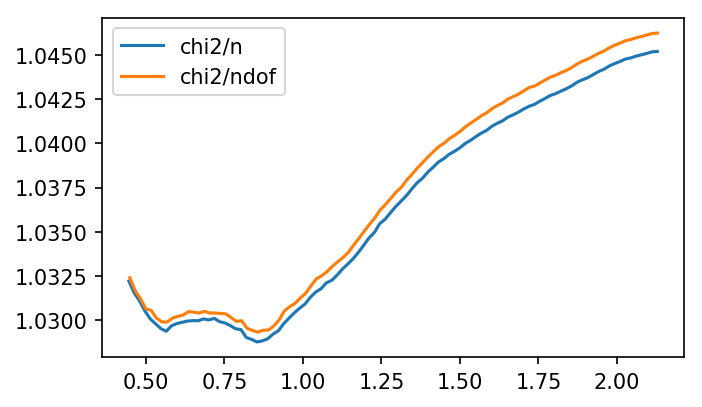

In [328]:
plt.figure(figsize=(5,3), dpi=150)
plt.plot(res_dic_nored['par_array'],res_dic_nored['chi2']/spec_sel.I.size, label='chi2/n')
plt.plot(res_dic['par_array'],res_dic['chi2'], label='chi2/ndof')

plt.legend()

In [329]:
model_E, model_ds, model_ss, model_field, chi2 = mth.get_models(spec_sel, fitdic_nored['eta'],
                                                                edge=1.4,ntau=512)
model_nored=mth.ModelSpec(eta=fitdic['eta'], mI=model_ds, mIs=model_ss, mE=model_E, mEs=model_field,
                         spec=spec_sel)
model_E, model_ds, model_ss, model_field, chi2 = mth.get_models(spec_sel, fitdic['eta'],
                                                                edge=1.4,ntau=512)
model_spec=mth.ModelSpec(eta=fitdic['eta'], mI=model_ds, mIs=model_ss, mE=model_E, mEs=model_field,
                         spec=spec_sel)

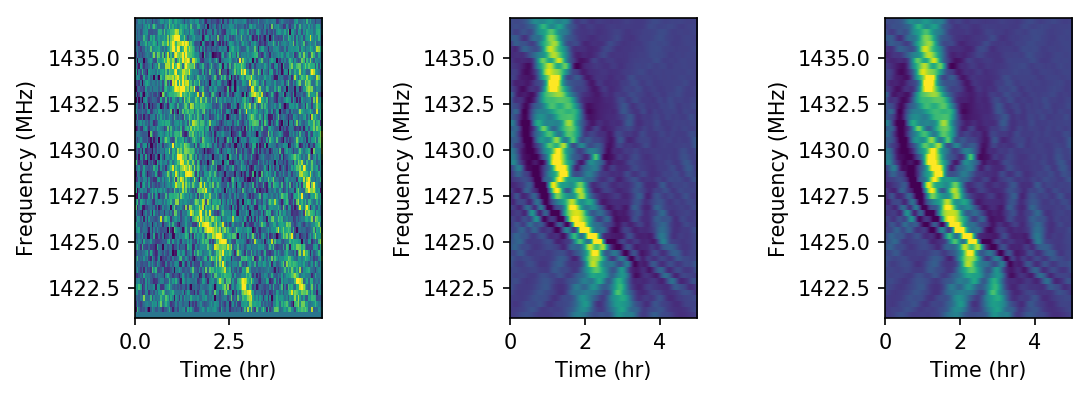

In [330]:
fig=plt.figure(figsize=(5,2), dpi=150)
fig.add_axes([0.0,0.0,0.25,1])
plt.gca()
spec_sel2.plot_ds(new_fig=False)
fig.add_axes([0.5,0.0,0.25,1])
plt.gca()
model_spec.plot_mds(new_fig=False)
fig.add_axes([1.0,0.0,0.25,1])
plt.gca()
model_nored.plot_mds(new_fig=False)

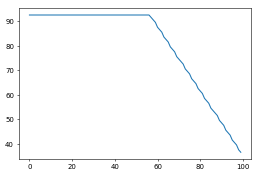

In [252]:
plt.plot(res_dic['ntheta_red'])

# Worse observation:

(1439, 512)
(89, 512)
(89, 512)
(89, 512) (89, 512)


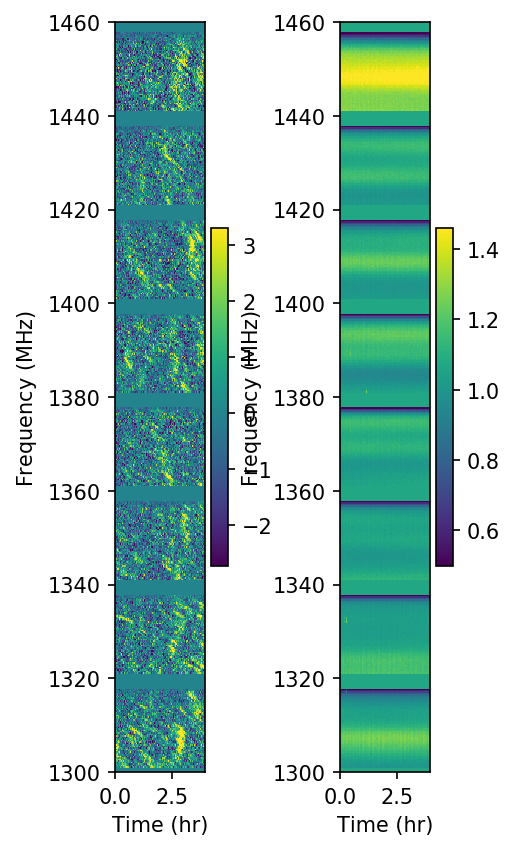

In [340]:
sp=dsa.load_triple_spectrum(list_2to4[1], factor=[16,1], wnoise=True, mean0=True)
print (np.shape(sp.I), np.shape(sp.nI))

i=6
spec_sel2=sp.select(time_sel=[sp.stend[0]*u.d,sp.stend[1]*u.d],
                                            freq_sel=[spec_pieces[i,0]*u.MHz,spec_pieces[i,1]*u.MHz])

spec_sel2.ss=spec_sel2.make_ss(pad_it=True, npad=3)



fig=plt.figure(figsize=(3,5), dpi=150)
fig.add_axes([0.0,0.0,0.25,1])
plt.gca()
sp.plot_ds(new_fig=False)
plt.colorbar()
fig.add_axes([0.5,0.0,0.25,1])
plt.gca()
sp.plot_nds(new_fig=False)
plt.colorbar()

In [334]:
this_spec=dsa.load_triple_spectrum(list_2to4[1], factor=[1,1], wnoise=True)
i=6
spec_sel=this_spec.select(time_sel=[this_spec.stend[0]*u.d,this_spec.stend[1]*u.d],
                                            freq_sel=[spec_pieces[i,0]*u.MHz,spec_pieces[i,1]*u.MHz])
spec_sel.ss=spec_sel.make_ss(pad_it=True, npad=3)

(1439, 512)
(1439, 512)
(1439, 512)


In [336]:
#try thth_redplot
fitdic, fit_freq, fit_time, res_dic=fth.daniel_pars_fit(spec_sel, curv_par='dveff', etas_pars=[0.5,11.5,0.25],
                                                       d_eff=0.325*u.kpc)
print (fitdic['dveff'], fitdic['mueff'], fitdic['eta'])

fit: <Dynamic spectrum: Dur: 4.00 hr, Freq: 1420.86 - 1437 MHz, MJD: 56071.30, PSR: PSRJ0337+1715, Tel: WSRT, w noise>
1.527256008277656 km / (pc(1/2) s) 17.87276809024844 mas / yr 0.9710730932370664 us / mHz2


In [337]:
fitdic_nored, fit_freq, fit_time, res_dic_nored=fth.daniel_pars_fit(spec_sel, curv_par='dveff', d_eff=0.325*u.kpc,
                                                                    etas_pars=[0.5,11.5,0.1],reduced=False)
print (fitdic_nored['dveff'], fitdic_nored['mueff'], fitdic_nored['eta'])

fit: <Dynamic spectrum: Dur: 4.00 hr, Freq: 1420.86 - 1437 MHz, MJD: 56071.30, PSR: PSRJ0337+1715, Tel: WSRT, w noise>
1.5708140379001005 km / (pc(1/2) s) 18.382507490644098 mas / yr 0.9179648626934633 us / mHz2


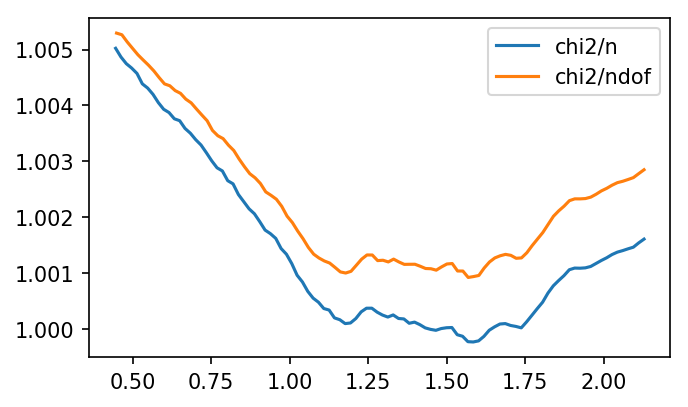

In [338]:
plt.figure(figsize=(5,3), dpi=150)
plt.plot(res_dic_nored['par_array'],res_dic_nored['chi2']/spec_sel.I.size, label='chi2/n')
plt.plot(res_dic['par_array'],res_dic['chi2'], label='chi2/ndof')

plt.legend()

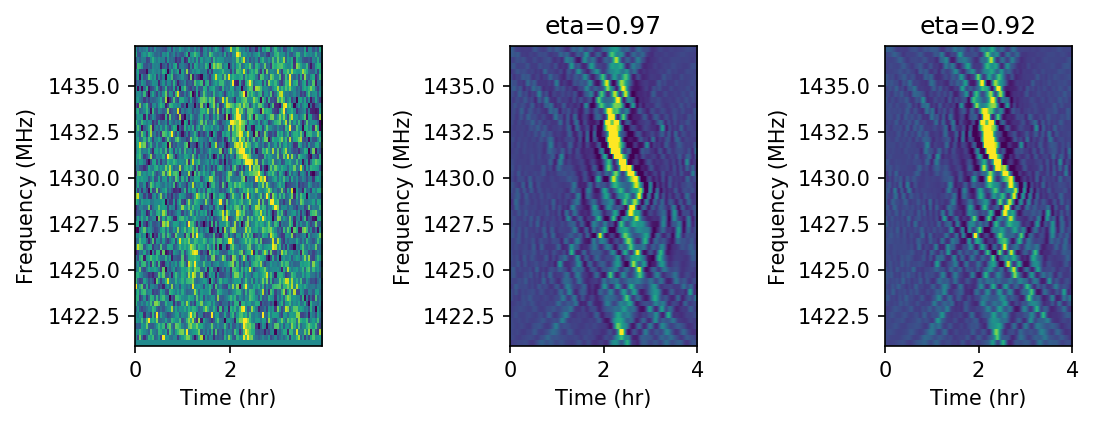

In [342]:
model_E, model_ds, model_ss, model_field, chi2 = mth.get_models(spec_sel, fitdic_nored['eta'],
                                                                edge=1.4,ntau=512)
model_nored=mth.ModelSpec(eta=fitdic['eta'], mI=model_ds, mIs=model_ss, mE=model_E, mEs=model_field,
                         spec=spec_sel)
model_E, model_ds, model_ss, model_field, chi2 = mth.get_models(spec_sel, fitdic['eta'],
                                                                edge=1.4,ntau=512)
model_spec=mth.ModelSpec(eta=fitdic['eta'], mI=model_ds, mIs=model_ss, mE=model_E, mEs=model_field,
                         spec=spec_sel)

fig=plt.figure(figsize=(5,2), dpi=150)
fig.add_axes([0.0,0.0,0.25,1])
plt.gca()
spec_sel2.plot_ds(new_fig=False)
fig.add_axes([0.5,0.0,0.25,1])
plt.gca()
model_spec.plot_mds(new_fig=False)
plt.title('eta=%.2f'% fitdic['eta'].value)
fig.add_axes([1.0,0.0,0.25,1])
plt.gca()
model_nored.plot_mds(new_fig=False)
plt.title('eta=%.2f'% fitdic_nored['eta'].value)

# Different window

In [343]:
this_spec=dsa.load_triple_spectrum(list_2to4[1], factor=[1,1], wnoise=True)
i=0
spec_sel=this_spec.select(time_sel=[this_spec.stend[0]*u.d,this_spec.stend[1]*u.d],
                                            freq_sel=[spec_pieces[i,0]*u.MHz,spec_pieces[i,1]*u.MHz])
spec_sel.ss=spec_sel.make_ss(pad_it=True, npad=3)

(1439, 512)
(1439, 512)
(1439, 512)


In [344]:
#try thth_redplot
fitdic, fit_freq, fit_time, res_dic=fth.daniel_pars_fit(spec_sel, curv_par='dveff', etas_pars=[0.5,11.5,0.25],
                                                       d_eff=0.325*u.kpc)
print (fitdic['dveff'], fitdic['mueff'], fitdic['eta'])

fit: <Dynamic spectrum: Dur: 4.00 hr, Freq: 1300.94 - 1317 MHz, MJD: 56071.30, PSR: PSRJ0337+1715, Tel: WSRT, w noise>
1.3462232683785982 km / (pc(1/2) s) 15.754225973261134 mas / yr 1.4896300282119666 us / mHz2


In [345]:
fitdic_nored, fit_freq, fit_time, res_dic_nored=fth.daniel_pars_fit(spec_sel, curv_par='dveff', d_eff=0.325*u.kpc,
                                                                    etas_pars=[0.5,11.5,0.1],reduced=False)
print (fitdic_nored['dveff'], fitdic_nored['mueff'], fitdic_nored['eta'])

fit: <Dynamic spectrum: Dur: 4.00 hr, Freq: 1300.94 - 1317 MHz, MJD: 56071.30, PSR: PSRJ0337+1715, Tel: WSRT, w noise>
1.3583381519145896 km / (pc(1/2) s) 15.89600083137633 mas / yr 1.463176797934932 us / mHz2


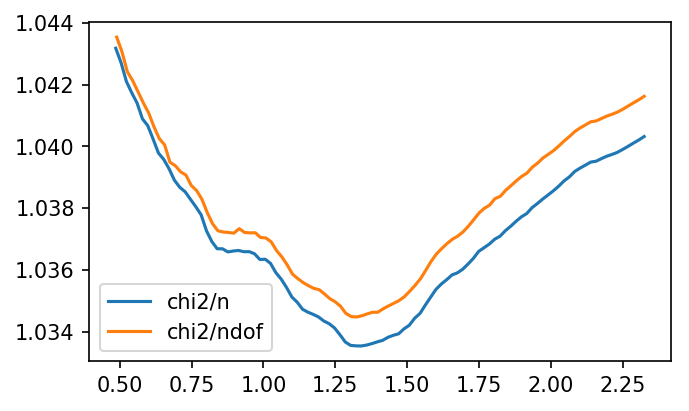

In [346]:
plt.figure(figsize=(5,3), dpi=150)
plt.plot(res_dic_nored['par_array'],res_dic_nored['chi2']/spec_sel.I.size, label='chi2/n')
plt.plot(res_dic['par_array'],res_dic['chi2'], label='chi2/ndof')

plt.legend()

(1439, 512)
(89, 512)
(89, 512)


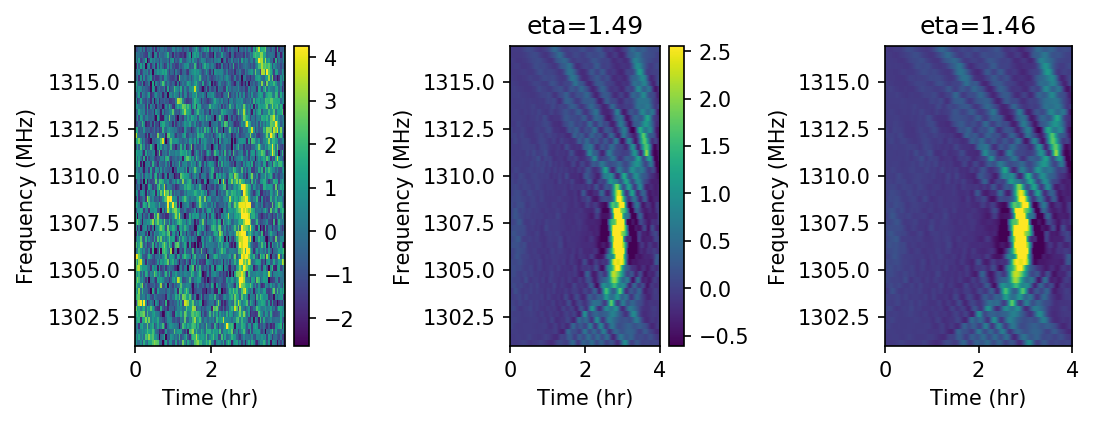

In [348]:
sp=dsa.load_triple_spectrum(list_2to4[1], factor=[16,1], wnoise=True, mean0=True)
i=0
spec_sel2=sp.select(time_sel=[sp.stend[0]*u.d,sp.stend[1]*u.d],
                                            freq_sel=[spec_pieces[i,0]*u.MHz,spec_pieces[i,1]*u.MHz])
spec_sel2.ss=spec_sel2.make_ss(pad_it=True, npad=3)

model_E, model_ds, model_ss, model_field, chi2 = mth.get_models(spec_sel, fitdic_nored['eta'],
                                                                edge=1.4,ntau=512)
model_nored=mth.ModelSpec(eta=fitdic['eta'], mI=model_ds, mIs=model_ss, mE=model_E, mEs=model_field,
                         spec=spec_sel)
model_E, model_ds, model_ss, model_field, chi2 = mth.get_models(spec_sel, fitdic['eta'],
                                                                edge=1.4,ntau=512)
model_spec=mth.ModelSpec(eta=fitdic['eta'], mI=model_ds, mIs=model_ss, mE=model_E, mEs=model_field,
                         spec=spec_sel)

fig=plt.figure(figsize=(5,2), dpi=150)
fig.add_axes([0.0,0.0,0.25,1])
plt.gca()
spec_sel2.plot_ds(new_fig=False)
plt.colorbar()
fig.add_axes([0.5,0.0,0.25,1])
plt.gca()
model_spec.plot_mds(new_fig=False)
plt.title('eta=%.2f'% fitdic['eta'].value)
plt.colorbar()
fig.add_axes([1.0,0.0,0.25,1])
plt.gca()
model_nored.plot_mds(new_fig=False)
plt.title('eta=%.2f'% fitdic_nored['eta'].value)

eta: 3.0686033681568023 us / mHz2 mueff: 5.0270986318021675 mas / yr dveff: 0.8591468932910574 km / (pc(1/2) s)
eta_err: 0.12211216543763437 us / mHz2 mueff: 0.10002431499751967 mas / yr dveff_err: 0.017094468554892477 km / (pc(1/2) s)


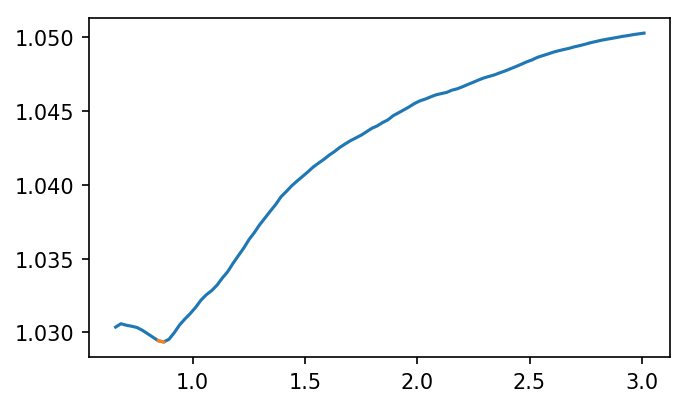

In [293]:
plt.figure(figsize=(5,3), dpi=150)
dic=res_dic
plt.plot(dic['par_array'],dic['chi2'])

fitted_range=((dic['par_array']>(dic['par_fit']-dic['par_sig']))&(dic['par_array']<(dic['par_fit']+dic['par_sig'])))

plt.plot(dic['par_array'][fitted_range],dic['chi2'][fitted_range])

print ('eta:', fitdic['eta'], 'mueff:', fitdic['mueff'], 'dveff:',  fitdic['dveff'])
print ('eta_err:', fitdic['eta_err'], 'mueff:', fitdic['mueff_err'], 'dveff_err:',  fitdic['dveff_err'])

In [261]:
fitdic_nored, fit_freq, fit_time, res_dic_nored=fth.daniel_pars_fit(spec_sel, curv_par='dveff',
                                                                    etas_pars=[0.25,5.5,0.1],reduced=False)

fit: <Dynamic spectrum: Dur: 5.00 hr, Freq: 1420.86 - 1437 MHz, MJD: 56074.31, PSR: PSRJ0337+1715, Tel: WSRT, w noise>


In [267]:
spec_sel.f.ptp()

<Quantity 16.281800391389424 MHz>

In [262]:
fitdic_nored['dveff']

<Quantity 0.856465704835496 km / (pc(1/2) s)>

In [263]:
fitdic_nored['mueff']

<Quantity 5.01141027987794 mas / yr>

In [264]:
fitdic_nored['eta']

<Quantity 3.087846128462989 us / mHz2>

eta: 3.087846128462989 us / mHz2 mueff: 5.01141027987794 mas / yr dveff: 0.856465704835496 km / (pc(1/2) s)
eta_err: 0.1439676988123017 us / mHz2 mueff: 0.11682596473119364 mas / yr dveff_err: 0.01996592309121926 km / (pc(1/2) s)


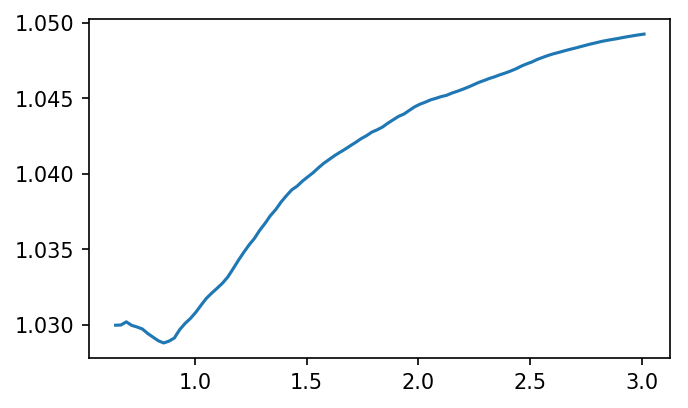

In [265]:
plt.figure(figsize=(5,3), dpi=150)
dic=res_dic_nored
fdic=fitdic_nored
plt.plot(dic['par_array'],dic['chi2']/spec_sel.I.size)

fitted_range=((dic['par_array']>(dic['par_fit']-dic['par_sig']))&(dic['par_array']<(dic['par_fit']+dic['par_sig'])))

plt.plot(dic['par_array'][fitted_range],dic['chi2'][fitted_range]/spec_sel.I.size)

print ('eta:', fdic['eta'], 'mueff:', fdic['mueff'], 'dveff:',  fdic['dveff'])
print ('eta_err:', fdic['eta_err'], 'mueff:', fdic['mueff_err'], 'dveff_err:',  fdic['dveff_err'])

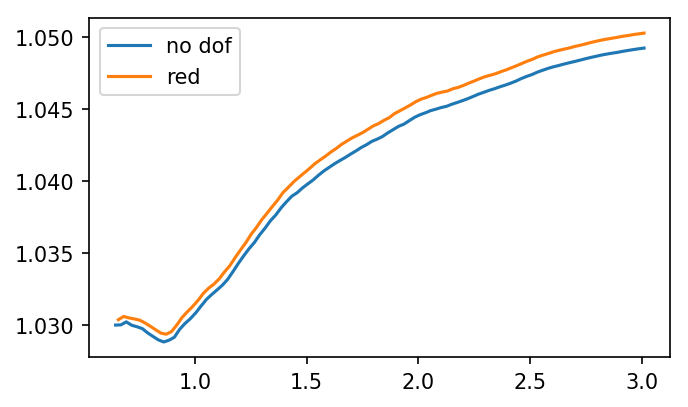

In [259]:
plt.figure(figsize=(5,3), dpi=150)
dic=res_dic_nored
plt.plot(res_dic_nored['par_array'],res_dic_nored['chi2']/spec_sel.I.size, label='no dof')

plt.plot(res_dic['par_array'],res_dic['chi2'], label='red')

plt.legend()


eta: 3.0686033681568023 us / mHz2 mueff: 10.054197263604339 mas / yr dveff: 0.8591468932910574 km / (pc(1/2) s)
eta_err: 0.12211216543763437 us / mHz2 mueff: 0.20004862999503942 mas / yr dveff_err: 0.017094468554892477 km / (pc(1/2) s)


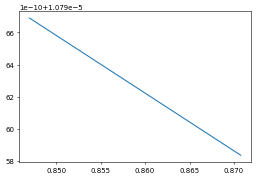

In [305]:
fitted_range=((dic['par_array']>(dic['par_fit']-dic['par_sig']))&(dic['par_array']<(dic['par_fit']+dic['par_sig'])))

plt.plot(dic['par_array'][fitted_range],dic['chi2'][fitted_range]/spec_sel.I.size)

print ('eta:', fitdic['eta'], 'mueff:', fitdic['mueff'], 'dveff:',  fitdic['dveff'])
print ('eta_err:', fitdic['eta_err'], 'mueff:', fitdic['mueff_err'], 'dveff_err:',  fitdic['dveff_err'])

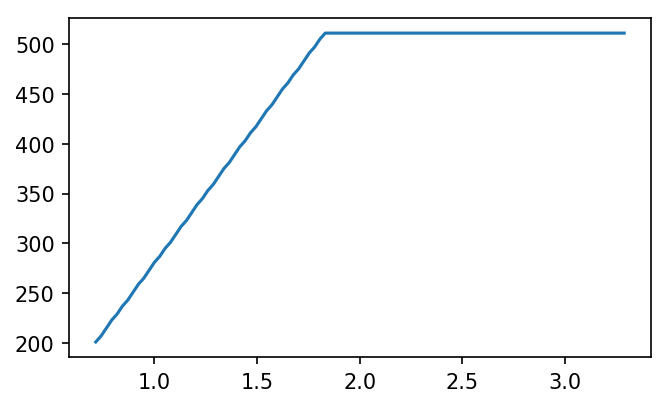

In [42]:
plt.figure(figsize=(5,3), dpi=150)
plt.plot(res_dic['par_array'],res_dic['thth_reds0'])

In [51]:
spec_sel.I.size-res_dic['thth_reds0'][0]*2

73806.0

In [226]:
fitdic['dveff']

<Quantity 1.4115015586039001 km / (pc(1/2) s)>

In [298]:
model_E, model_ds, model_ss, model_field, chi2 = mth.get_models(spec_sel, fitdic['eta'],
                                                                edge=1.4,ntau=512)

model_spec=mth.ModelSpec(eta=fitdic['eta'], mI=model_ds, mIs=model_ss, mE=model_E, mEs=model_field,
                         spec=spec_sel)

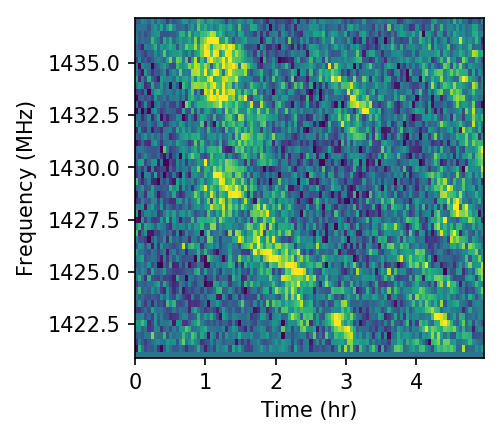

In [304]:
spec_sel2.plot_ds(figsize=(3,3))

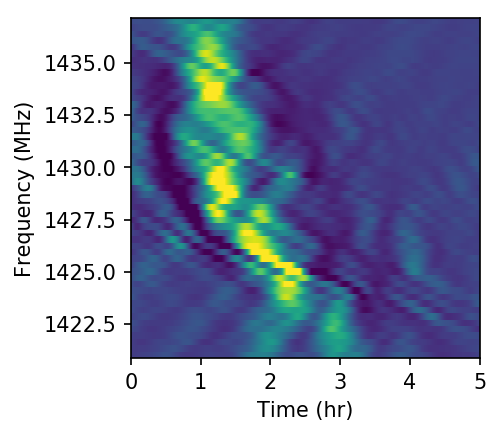

In [301]:
model_spec.plot_mds()

In [100]:
spec_sel.I.shape[0]*spec_sel.I.shape[1]

74828

In [303]:
this_spec=dsa.load_triple_spectrum(list_2to4[4], factor=[16,1], wnoise=True)
i=6
spec_sel2=this_spec.select(time_sel=[this_spec.stend[0]*u.d,this_spec.stend[1]*u.d],
                                            freq_sel=[spec_pieces[i,0]*u.MHz,spec_pieces[i,1]*u.MHz])

spec_sel2.ss=spec_sel2.make_ss(pad_it=True, npad=3)

(1799, 512)
(112, 512)
(112, 512)


In [43]:
spec_sel.I.size

74828

In [ ]:
fitdic, fit_freq, fit_time, res_dic=fth.daniel_pars_fit(spec_sel, curv_par='dveff', etas_pars=[0.25,5.5,0.25])

In [48]:
spec_sel.I.sum()/spec_sel.I.size

0.34511254286765464

In [47]:
spec_sel.I.mean()

0.34511254286765464

# Fit multiple windows

In [ ]:
def get_curv_fits_wsrt(name, figsize=(5,7.5), spec_pieces='Default', etas_pars=[0.25,7.5,0.25], method='chi2',
                      pc7=False, load_model=False, eta_ref=None, ref_freq=None, edge=1.4, save_models=False,
                      who='Daniel', d_eff=1300*u.pc):
    if spec_pieces=='Default':
        if pc7 is True:
            spec_pieces=np.array([[1312,1328],[1332,1348],[1352,1368],[1372,1388],[1392,1408],
                      [1412,1428],[1432,1448]])
        else:
            spec_pieces=np.array([[1301,1317],[1321,1337],[1341,1357],[1361,1377],[1381,1397],
                      [1401,1417],[1421,1437],[1441,1457]])
    else:
        spec_pieces=spec_pieces
    shr_spec=load_triple_spectrum(name, factor=[16,1])
    this_spec=load_triple_spectrum(name, factor=[1,1])
    
    my_specs=[]
    shr_specs=[]
    if (shr_spec.stend[1]-shr_spec.stend[0])>3.2/24.:
        break_mjd=(shr_spec.stend[1]+shr_spec.stend[0])/2
        st_spec=this_spec.select(time_sel=[this_spec.stend[0]*u.d,break_mjd*u.d])
        end_spec=this_spec.select(time_sel=[break_mjd*u.d,this_spec.stend[1]*u.d])
        my_specs.append(st_spec)
        my_specs.append(end_spec)
        
        st_spec_shr=shr_spec.select(time_sel=[shr_spec.stend[0]*u.d,break_mjd*u.d])
        end_spec_shr=shr_spec.select(time_sel=[break_mjd*u.d,shr_spec.stend[1]*u.d])
        shr_specs.append(st_spec_shr)
        shr_specs.append(end_spec_shr)
    else:
        my_specs.append(this_spec)
        shr_specs.append(shr_spec)
    
    etas, etas_err, etas_f, etas_t, dics_etas, all_models, delays=[],[],[],[],[],[],[]
    f = open("etas_results_fit_%.2f_%s.txt"%(this_spec.stend[0],who), "a")
    if load_model is False:
        h = open("delay_results_fit_%.2f_%s.txt"%(this_spec.stend[0],who), "a")
    else:
        h = open("delay_results_model_%.2f.txt"%this_spec.stend[0], "a")
    j=0
    for my_spec in my_specs:
        fig=plt.figure(figsize=figsize, dpi= 70, facecolor='w', edgecolor='k')
        fig.add_axes([0.0,0.0,0.25,1.0])
        plt.gca()
        shr_specs[j].plot_ds(new_fig=False)
        for i in range(0,spec_pieces.shape[0]):
            spec_sel=my_spec.select(time_sel=[my_spec.stend[0]*u.d,my_spec.stend[1]*u.d],
                                            freq_sel=[spec_pieces[i,0]*u.MHz,spec_pieces[i,1]*u.MHz])
            fig.add_axes([0.9,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            spec_sel.plot_ss(new_fig=False, cb=False, fd_lim=[-2.0,2.0], tau_lim=[0.0,1.3],vmin=1e7,vmax=1e9)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            spec_sel.get_noise()
            if load_model is False:
                if who=='Daniel':
                    eta, eta_err, eta_f, eta_t, dic_etas=get_daniel_eta_fit(spec_sel, etas_pars=etas_pars,
                                                                                edge=edge,ntau=512,method=method)
                if who=='Marten':
                    eta, eta_err, eta_f, eta_t, dic_etas=get_marten_mueff_fit(spec_sel, d_eff,
                                                        etas_pars=etas_pars, edge=edge,ntau=512)
                if np.isnan(eta):
                    if i==0:
                        print ('not correct eta, take highest value')
                        eta=etas_pars[1]*eta_err.unit
                    else:
                        print ('scales eta, because the fit did not converge')
                        eta=etas[i-1]*(etas_f[i-1]/eta_f)**2
                f.write('%.3f, %.3f, %.3f, %.3f \n'%(eta.value, eta_err.value, eta_f.value, eta_t))
                dics_etas.append(dic_etas)
            else:
                eta=eta_ref*(ref_freq/spec_sel.f.mean())**2
                eta_err=0.0*eta.unit
                eta_f=np.mean(spec_sel.f)
                eta_t=np.mean(spec_sel.mjd.mjd)
                
            etas.append(eta)
            etas_err.append(eta_err)
            etas_f.append(eta_f)
            etas_t.append(eta_t)
                    
            print (eta, eta_err, eta_f, eta_t)
            
            model_E, model_ds, model_ss, model_field = get_models(spec_sel, eta, edge=edge,ntau=512)
            model_spec=ModelSpec(eta=eta, mI=model_ds, mIs=model_ss, mE=model_E, mEs=model_field,
                                     spec=spec_sel)
            extent=ext_find(model_spec.spec.ss.fd, model_spec.spec.ss.tau)
            tau_axis=np.linspace(extent[2],extent[3], np.shape(model_spec.mEs)[0])
            delay_es=model_spec.mEs.sum(1)
            tau_axis_pos=tau_axis[(tau_axis>0)]
            delay_es_pos=delay_es[(tau_axis>0)]
            my_delay=np.average(tau_axis_pos, weights=delay_es_pos)
            h.write('%.3f, %.3f, %.3f \n'%(my_delay, eta_f.value, eta_t))
            delays.append(my_delay)
            
            fig.add_axes([0.3,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_mds(new_fig=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([0.6,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_me(new_fig=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([1.2,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_mss(new_fig=False, cb=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([1.5,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_mes(new_fig=False, cb=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([1.8,0.006+0.125*i,0.25, 0.105])
            if save_models is True:
                all_models.append(model_spec)
            if load_model is False:
                frame1=plt.gca()
                plot_etas(dic_etas,new_fig=False)
                frame1.axes.get_xaxis().set_ticks([])
                frame1.axes.get_yaxis().set_ticks([])
                aux_name='fullfit'
            else:
                aux_name='fullmodel_%.1f'%eta.value
            print ('----------')
        plt.savefig('triple_%.2f_%s_%s_%s.png'%(my_spec.stend[0],my_spec.tel,aux_name,who),format='png',
                    bbox_inches='tight',dpi=70)
        plt.show()
        j=j+1
    f.close()
    h.close()
    return etas, etas_err, etas_f, etas_t, dics_etas, all_models, delays


In [ ]:
def get_curv_fits_wsrt(name, figsize=(5,7.5), spec_pieces='Default', etas_pars=[0.25,7.5,0.25], method='chi2',
                      pc7=False, load_model=False, eta_ref=None, ref_freq=None, edge=1.4, save_models=False,
                      who='Daniel', d_eff=1300*u.pc):
    if spec_pieces=='Default':
        if pc7 is True:
            spec_pieces=np.array([[1312,1328],[1332,1348],[1352,1368],[1372,1388],[1392,1408],
                      [1412,1428],[1432,1448]])
        else:
            spec_pieces=np.array([[1301,1317],[1321,1337],[1341,1357],[1361,1377],[1381,1397],
                      [1401,1417],[1421,1437],[1441,1457]])
    else:
        spec_pieces=spec_pieces
    shr_spec=load_triple_spectrum(name, factor=[16,1])
    this_spec=load_triple_spectrum(name, factor=[1,1])

    my_specs=[]
    shr_specs=[]
    if (shr_spec.stend[1]-shr_spec.stend[0])>3.2/24.:
        break_mjd=(shr_spec.stend[1]+shr_spec.stend[0])/2
        st_spec=this_spec.select(time_sel=[this_spec.stend[0]*u.d,break_mjd*u.d])
        end_spec=this_spec.select(time_sel=[break_mjd*u.d,this_spec.stend[1]*u.d])
        my_specs.append(st_spec)
        my_specs.append(end_spec)

        st_spec_shr=shr_spec.select(time_sel=[shr_spec.stend[0]*u.d,break_mjd*u.d])
        end_spec_shr=shr_spec.select(time_sel=[break_mjd*u.d,shr_spec.stend[1]*u.d])
        shr_specs.append(st_spec_shr)
        shr_specs.append(end_spec_shr)
    else:
        my_specs.append(this_spec)
        shr_specs.append(shr_spec)

    etas, etas_err, etas_f, etas_t, dics_etas, all_models, delays=[],[],[],[],[],[],[]
    f = open("etas_results_fit_%.2f_%s.txt"%(this_spec.stend[0],who), "a")
    if load_model is False:
        h = open("delay_results_fit_%.2f_%s.txt"%(this_spec.stend[0],who), "a")
    else:
        h = open("delay_results_model_%.2f.txt"%this_spec.stend[0], "a")
    j=0
    for my_spec in my_specs:
        fig=plt.figure(figsize=figsize, dpi= 70, facecolor='w', edgecolor='k')
        fig.add_axes([0.0,0.0,0.25,1.0])
        plt.gca()
        shr_specs[j].plot_ds(new_fig=False)
        for i in range(0,spec_pieces.shape[0]):
            spec_sel=my_spec.select(time_sel=[my_spec.stend[0]*u.d,my_spec.stend[1]*u.d],
                                            freq_sel=[spec_pieces[i,0]*u.MHz,spec_pieces[i,1]*u.MHz])
            fig.add_axes([0.9,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            spec_sel.plot_ss(new_fig=False, cb=False, fd_lim=[-2.0,2.0], tau_lim=[0.0,1.3],vmin=1e7,vmax=1e9)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            spec_sel.get_noise()
            if load_model is False:

                if who=='Daniel':
                    eta, eta_err, eta_f, eta_t, dic_etas=get_daniel_eta_fit(spec_sel, etas_pars=etas_pars,
                                                                                edge=edge,ntau=512,method=method)
                if who=='Marten':
                    eta, eta_err, eta_f, eta_t, dic_etas=get_marten_mueff_fit(spec_sel, d_eff,
                                                        etas_pars=etas_pars, edge=edge,ntau=512)
                if np.isnan(eta):
                    if i==0:
                        print ('not correct eta, take highest value')
                        eta=etas_pars[1]*eta_err.unit
                    else:
                        print ('scales eta, because the fit did not converge')
                        eta=etas[i-1]*(etas_f[i-1]/eta_f)**2
                f.write('%.3f, %.3f, %.3f, %.3f \n'%(eta.value, eta_err.value, eta_f.value, eta_t))
                dics_etas.append(dic_etas)
            else:
                eta=eta_ref*(ref_freq/spec_sel.f.mean())**2
                eta_err=0.0*eta.unit
                eta_f=np.mean(spec_sel.f)
                eta_t=np.mean(spec_sel.mjd.mjd)

            etas.append(eta)
            etas_err.append(eta_err)
            etas_f.append(eta_f)
            etas_t.append(eta_t)

            print (eta, eta_err, eta_f, eta_t)

            model_E, model_ds, model_ss, model_field = get_models(spec_sel, eta, edge=edge,ntau=512)
            model_spec=ModelSpec(eta=eta, mI=model_ds, mIs=model_ss, mE=model_E, mEs=model_field,
                                     spec=spec_sel)
            extent=ext_find(model_spec.spec.ss.fd, model_spec.spec.ss.tau)
            tau_axis=np.linspace(extent[2],extent[3], np.shape(model_spec.mEs)[0])
            delay_es=model_spec.mEs.sum(1)
            tau_axis_pos=tau_axis[(tau_axis>0)]
            delay_es_pos=delay_es[(tau_axis>0)]
            my_delay=np.average(tau_axis_pos, weights=delay_es_pos)
            h.write('%.3f, %.3f, %.3f \n'%(my_delay, eta_f.value, eta_t))
            delays.append(my_delay)

            fig.add_axes([0.3,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_mds(new_fig=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([0.6,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_me(new_fig=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([1.2,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_mss(new_fig=False, cb=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([1.5,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_mes(new_fig=False, cb=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([1.8,0.006+0.125*i,0.25, 0.105])
            if save_models is True:
                all_models.append(model_spec)
            if load_model is False:
                frame1=plt.gca()
                plot_etas(dic_etas,new_fig=False)
                frame1.axes.get_xaxis().set_ticks([])
                frame1.axes.get_yaxis().set_ticks([])
                aux_name='fullfit'
            else:
                aux_name='fullmodel_%.1f'%eta.value
            print ('----------')
        plt.savefig('triple_%.2f_%s_%s_%s.png'%(my_spec.stend[0],my_spec.tel,aux_name,who),format='png',
                    bbox_inches='tight',dpi=70)
        plt.show()
        j=j+1
    f.close()
    h.close()
    return etas, etas_err, etas_f, etas_t, dics_etas, all_models, delays


In [ ]:
def get_daniel_dveff_fit_wsrt(myspec, etas_pars=[0.5,7.5,0.25], edge=1.4,ntau=512,
                            spec_pieces='Default', neta=100, ind_mean0=True):
    print ('Method chi2:', myspec)
    if spec_pieces=='Default':
        spec_pieces=np.array([[1301,1317],[1321,1337],[1341,1357],[1361,1377],[1381,1397],
                      [1401,1417],[1421,1437],[1441,1457]])
    
    
    etas_init=np.arange(etas_pars[0],etas_pars[1],etas_pars[2])
    ##Define range of curvatures to search
    eta_low=np.amin(etas_init)*u.us/(u.mHz**2)
    eta_high=np.amax(etas_init)*u.us/(u.mHz**2)

    dveff_low=eta_to_dveff(eta_high, myspec)
    dveff_high=eta_to_dveff(eta_low, myspec)

    dveffs2=np.linspace(dveff_high.value,dveff_low.value,neta)*dveff_low.unit
    chisq=np.zeros(dveffs2.shape[0])
    edges=np.linspace(-edge,edge,ntau)
    ref_freq=myspec.f.mean()
    
    specs=[]
    for i in range(0,spec_pieces.shape[0]):
        spec_sel=myspec.select(time_sel=[myspec.stend[0]*u.d,myspec.stend[1]*u.d],
                                        freq_sel=[spec_pieces[i,0]*u.MHz,spec_pieces[i,1]*u.MHz])
        if ind_mean0 is True:
            spec_sel.I=spec_sel.I-np.mean(spec_sel.I)
            spec_sel.ss=spec_sel.make_ss(pad_it=True, npad=3)
        specs.append(spec_sel)
    
    for i in range(dveffs2.shape[0]):
        dveff=dveffs2[i]
        this_chi2s=[]
        etas3=[]
        for spec_p in specs:
            eta=dveff_to_eta(dveffs2[i],spec_p)
            this_chi2=dsa.daniel_get_chi2_spec(spec_sel, eta, edge, ntau)
            this_chi2s.append(this_chi2)
            etas3.append(eta.value)
        chisq[i]=np.mean(this_chi2s)
        print (i, np.mean(etas3), dveff, chisq[i])
            
    dveff_min=dveffs2[chisq==chisq.min()][0]
    fit_results=chisq[np.abs(dveffs2-dveff_min)<.1*dveff_min]
    C=fit_results.min()            
    measure=chisq
    dveffs_fit=dveffs2[np.abs(dveffs2-dveff_min)<.1*dveff_min]
    x0=dveffs_fit[fit_results==C][0].value
    A=(fit_results[0]-C)/((dveffs_fit[0].value-x0)**2)
    
    try:
        popt,pcov=curve_fit(THTH.chi_par,dveffs_fit.value,fit_results,p0=np.array([A,x0,C]))
        dveff_fit=popt[1]*dveffs2.unit
        dveff_sig=np.sqrt((fit_results-THTH.chi_par(dveffs_fit.value,*popt)).std()/popt[0])*dveffs2.unit
    except RuntimeError:
        print('Fit curve didnt converge')
        vdeff_fit, dveff_sig, popt=float('nan') , 0.0*dveffs_fit.unit,  0.0
    except TypeError:
        print ('Improper input: N=3 must not exceed M=1; -- why?')
        vdeff_fit, dveff_sig, popt=float('nan') , 0.0*dveffs_fit.unit,  0.0
    
    dveffs_dic={'etas':dveffs2, 'etas_fit':dveffs_fit, 'measure':measure, 'etas_fit_res':popt,
              'eta_fit':dveff_fit, 'eta_sig':dveff_sig}
    return dveff_fit, dveff_sig, np.mean(myspec.f), np.mean(myspec.mjd.mjd), dveffs_dic


def get_curv_simfits_wsrt(name, figsize=(5,7.5), spec_pieces='Default', etas_pars=[0.5,7.5,0.25], method='chi2',
                      pc7=False, edge=1.4,who='Daniel', time_lim=2.5,
                       d_eff=1300*u.pc, mean0=True, ind_mean0=False):
    if spec_pieces=='Default':
        if pc7 is True:
            spec_pieces=np.array([[1312,1328],[1332,1348],[1352,1368],[1372,1388],[1392,1408],
                      [1412,1428],[1432,1448]])
        else:
            spec_pieces=np.array([[1301,1317],[1321,1337],[1341,1357],[1361,1377],[1381,1397],
                      [1401,1417],[1421,1437],[1441,1457]])
    else:
        spec_pieces=spec_pieces
    shr_spec=dsa.load_triple_spectrum(name, factor=[16,1], mean0=mean0)
    this_spec=dsa.load_triple_spectrum(name, factor=[1,1], mean0=mean0)
    
    my_specs=[]
    shr_specs=[]
    if (shr_spec.stend[1]-shr_spec.stend[0])>time_lim/24.:
        break_mjd=(shr_spec.stend[1]+shr_spec.stend[0])/2
        st_spec=this_spec.select(time_sel=[this_spec.stend[0]*u.d,break_mjd*u.d])
        end_spec=this_spec.select(time_sel=[break_mjd*u.d,this_spec.stend[1]*u.d])
        my_specs.append(st_spec)
        my_specs.append(end_spec)
        
        st_spec_shr=shr_spec.select(time_sel=[shr_spec.stend[0]*u.d,break_mjd*u.d])
        end_spec_shr=shr_spec.select(time_sel=[break_mjd*u.d,shr_spec.stend[1]*u.d])
        shr_specs.append(st_spec_shr)
        shr_specs.append(end_spec_shr)
    else:
        my_specs.append(this_spec)
        shr_specs.append(shr_spec)
    
    etas, etas_err, etas_f, etas_t, dics_etas=[],[],[],[],[]
    j=0
    for my_spec in my_specs:
        f = open("dveff_results_simfit_%s.txt"%who, "a")
        fig=plt.figure(figsize=figsize, dpi= 70, facecolor='w', edgecolor='k')
        fig.add_axes([0.0,0.0,0.25,1.0])
        plt.gca()
        shr_specs[j].plot_ds(new_fig=False)
        
        dveff_fit, dveff_sig, eta_freq, eta_mjd, etas_dic=get_daniel_dveff_fit_wsrt(my_spec, neta=100,
                                                                                etas_pars=etas_pars)
        f.write('%.3f, %.3f, %.3f, %.3f \n'%(dveff_fit.value, dveff_sig.value, eta_freq.value, eta_mjd))
        print ('%.3f, %.3f, %.3f, %.3f \n'%(dveff_fit.value, dveff_sig.value, eta_freq.value, eta_mjd))
        
        eta_ref=dveff_to_eta(dveff_fit, my_spec)
        ref_freq=my_spec.f.mean()
        for i in range(0,spec_pieces.shape[0]):
            spec_sel=my_spec.select(time_sel=[my_spec.stend[0]*u.d,my_spec.stend[1]*u.d],
                                            freq_sel=[spec_pieces[i,0]*u.MHz,spec_pieces[i,1]*u.MHz])
            
            fig.add_axes([0.9,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            spec_sel.plot_ss(new_fig=False, cb=False, fd_lim=[-2.0,2.0], tau_lim=[0.0,1.3],vmin=1e7,vmax=1e9)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])

            eta=eta_ref*(ref_freq/spec_sel.f.mean())**2
            eta_err=0.0*eta.unit
            eta_f=np.mean(spec_sel.f)
            eta_t=np.mean(spec_sel.mjd.mjd)
                
            etas.append(eta)
            etas_err.append(eta_err)
            etas_f.append(eta_f)
            etas_t.append(eta_t)
                    
            print (eta, eta_err, eta_f, eta_t)
            
            model_E, model_ds, model_ss, model_field, chi2 = dsa.get_models(spec_sel, eta, edge=edge,ntau=512)
            model_spec=dsa.ModelSpec(eta=eta, mI=model_ds, mIs=model_ss, mE=model_E, mEs=model_field,
                                     spec=spec_sel)
            
            fig.add_axes([0.3,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_mds(new_fig=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([0.6,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_me(new_fig=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([1.2,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_mss(new_fig=False, cb=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            fig.add_axes([1.5,0.006+0.125*i,0.25, 0.105])
            frame1=plt.gca()
            model_spec.plot_mes(new_fig=False, cb=False)
            frame1.axes.get_xaxis().set_ticks([])
            frame1.axes.get_yaxis().set_ticks([])
            print ('----------')
        fig.add_axes([1.8,0.006+0.125*4,0.25, 0.105])
        frame1=plt.gca()
        dsa.plot_etas(etas_dic,new_fig=False)
        frame1.axes.get_xaxis().set_ticks([])
        frame1.axes.get_yaxis().set_ticks([])
        aux_name='dveff_%.1f'%dveff_fit.value
        plt.savefig('triple_%.2f_%s_%s_%s.png'%(my_spec.stend[0],my_spec.tel,aux_name,who),format='png',
                    bbox_inches='tight',dpi=70)
        plt.show()
        j=j+1
        f.close()
    return etas, etas_err, etas_f, etas_t, dics_etas

In [ ]:
rd=np.load(list_2to4[1])

data=rd['data']
amp=rd['amp']
templ=rd['templ']
bg=rd['bg']
w=rd['weights']
dprof=(data*w[...,None]).mean(axis=(0,1))

fig=plt.figure(figsize=(5,3), dpi=150)
plt.plot(templ)
plt.plot(dprof)
plt.show()
fig=plt.figure(figsize=(5,3), dpi=150)
plt.plot(templ*dprof)
plt.show()
fig=plt.figure(figsize=(5,3), dpi=150)
plt.plot(tz*pz)
plt.show()
tz=templ-templ.mean()
d= data-data.mean(axis=-1, keepdims=True)
pz=dprof-np.mean(dprof)

tz_sc=tz*amp+bg
fig=plt.figure(figsize=(5,3), dpi=150)
plt.plot(tz)
plt.plot(pz)
plt.plot(tz_sc)
plt.show()


variance=np.var(d-tz_sc, axis=-1, keepdims=True)

j = np.sum(d*tz_sc, axis=-1)
all_data=j[w!=0]
j[w==0] = np.mean(all_data)


ns = np.sqrt(np.sum(variance*tz_sc**2, axis=-1))
all_noise=ns[w!=0]
ns[w==0] = np.mean(all_noise)

fc=16
j_shr=ld.shrink_2(j, factor=[fc,1])
ns_shr=ns/np.sqrt(fc)

fig=plt.figure(figsize=(3,5), dpi=150)
fig.add_axes([0.0,0.0,0.25,1])
plt.gca()
vmin, vmax=np.percentile(j_shr, [1,99])
plt.imshow(j_shr.T, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()
fig.add_axes([0.75,0.0,0.25,1])
plt.gca()
vmin, vmax=np.percentile(ns_shr, [1,99])
plt.imshow(ns_shr.T, aspect='auto', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()

print (np.std(j_shr), np.mean(ns_shr))